In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler
sns.set(style='whitegrid')

In [2]:
train = pd.read_csv('/kaggle/input/health-insurance-cross-sell-prediction/train.csv')
test = pd.read_csv('/kaggle/input/health-insurance-cross-sell-prediction/test.csv')
submission = pd.read_csv('/kaggle/input/health-insurance-cross-sell-prediction/sample_submission.csv')

**id -** Unique ID for the customer 

**Gender -** Gender of the customer - Binary Variable

**Age -** Age of the customer - 

**Driving_License -**	0 : Customer does not have DL, 1 : Customer already has DL - Categorical Variable

**Region_Code -**	Unique code for the region of the customer - Nominal Variable

**Previously_Insured -**	1 : Customer already has Vehicle Insurance, 0 : Customer doesn't have Vehicle Insurance - Categorical Variable

**Vehicle_Age -**	Age of the Vehicle - Ordinal Variable

**Vehicle_Damage -**
1 : Customer got his/her vehicle damaged in the past.
0 : Customer didn't get his/her vehicle damaged in the past.

**Annual_Premium -**	The amount customer needs to pay as premium in the year

**Policy_Sales_Channel -**	Anonymised Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.

**Vintage -**	Number of Days, Customer has been associated with the company

**Response -**	1 :  Customer is interested, 0 : Customer is not interested


In [3]:
train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [4]:
train.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [5]:
train['Response'].value_counts()

0    334399
1     46710
Name: Response, dtype: int64

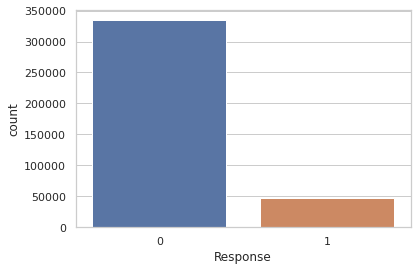

In [6]:
sns.countplot(train.Response)

This is a Imbalaced Classification Problem. We try to apply some of the Oversampling techniques like **SMOTE** to make the data balanced. Before doing so lets try to do some Feature labelling.

In [7]:
#converting Text Object to int type
train['Vehicle_Age']=train['Vehicle_Age'].replace({'< 1 Year':0,'1-2 Year':1,'> 2 Years':2})
train['Gender']=train['Gender'].replace({'Male':1,'Female':0})
train['Vehicle_Damage']=train['Vehicle_Damage'].replace({'Yes':1,'No':0})
test['Vehicle_Age']=test['Vehicle_Age'].replace({'< 1 Year':0,'1-2 Year':1,'> 2 Years':2})
test['Gender']=test['Gender'].replace({'Male':1,'Female':0})
test['Vehicle_Damage']=test['Vehicle_Damage'].replace({'Yes':1,'No':0})

In [8]:
train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,1,44,1,28.0,0,2,1,40454.0,26.0,217,1
1,2,1,76,1,3.0,0,1,0,33536.0,26.0,183,0
2,3,1,47,1,28.0,0,2,1,38294.0,26.0,27,1
3,4,1,21,1,11.0,1,0,0,28619.0,152.0,203,0
4,5,0,29,1,41.0,1,0,0,27496.0,152.0,39,0


In [9]:
test.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,381110,1,25,1,11.0,1,0,0,35786.0,152.0,53
1,381111,1,40,1,28.0,0,1,1,33762.0,7.0,111
2,381112,1,47,1,28.0,0,1,1,40050.0,124.0,199
3,381113,1,24,1,27.0,1,0,1,37356.0,152.0,187
4,381114,1,27,1,28.0,1,0,0,59097.0,152.0,297


In [10]:
x_train = train.drop(['id', 'Response'], axis = 1)
y_train = train['Response']
test = test.drop(['id'], axis = 1)

## Correlation

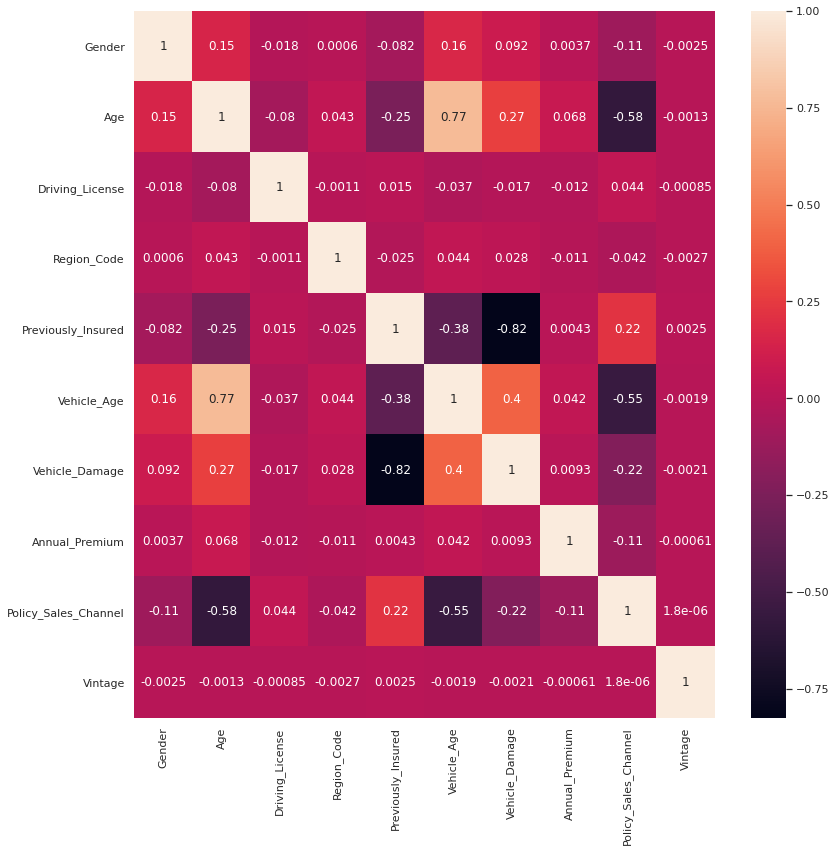

In [11]:
corrmat = x_train.corr()
fig, ax = plt.subplots()
fig.set_size_inches(13,13)
sns.heatmap(corrmat, annot = True)

Here we can observe a strong negative correlation between **Previously Insured** and **Vehicle Damage**.

## Mutual Information Test

In [12]:
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.feature_selection import SelectKBest, SelectPercentile

In [13]:
mi = mutual_info_classif(x_train.fillna(0), y_train)
mi

array([0.02208971, 0.03169885, 0.07371124, 0.01511248, 0.09847148,
       0.04529712, 0.09446039, 0.0037019 , 0.05811521, 0.00054339])

In [14]:
# let's add the variable names and order the features
# according to the MI for clearer visualisation
mi = pd.Series(mi)
mi.index = x_train.columns
mi.sort_values(ascending=False)

Previously_Insured      0.098471
Vehicle_Damage          0.094460
Driving_License         0.073711
Policy_Sales_Channel    0.058115
Vehicle_Age             0.045297
Age                     0.031699
Gender                  0.022090
Region_Code             0.015112
Annual_Premium          0.003702
Vintage                 0.000543
dtype: float64

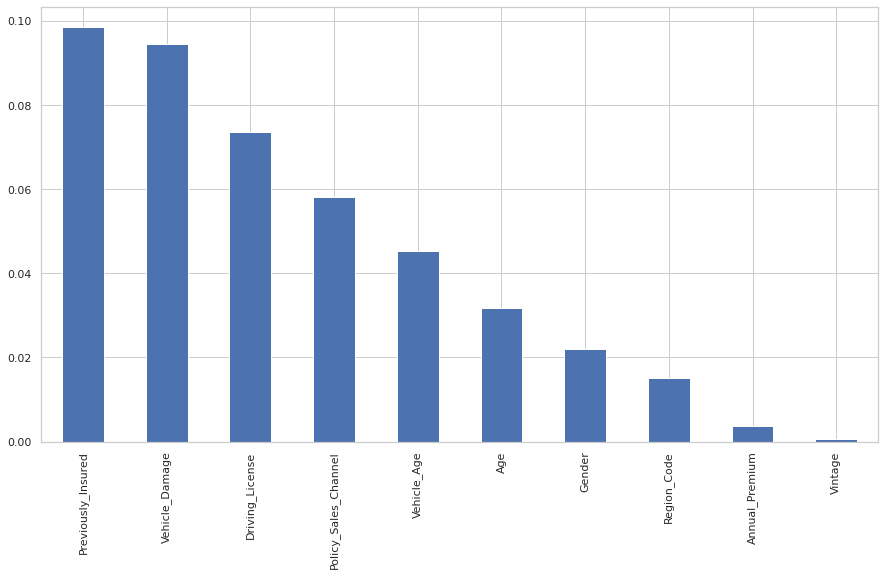

In [15]:
# and now let's plot the ordered MI values per feature
mi.sort_values(ascending=False).plot.bar(figsize=(15, 8))

**Vintage** Lets try to understand more about Vintage column and why it there is not much relation between the Target variable and Vintage.

In [16]:
x_train['Vintage_m'] = x_train['Vintage']/30.25
test['Vintage_m'] = test['Vintage']/30.25

In [17]:
x_train = x_train.apply(np.ceil)
test = test.apply(np.ceil)

In [18]:
x_train.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Vintage_m
0,1.0,44.0,1.0,28.0,0.0,2.0,1.0,40454.0,26.0,217.0,8.0
1,1.0,76.0,1.0,3.0,0.0,1.0,0.0,33536.0,26.0,183.0,7.0
2,1.0,47.0,1.0,28.0,0.0,2.0,1.0,38294.0,26.0,27.0,1.0
3,1.0,21.0,1.0,11.0,1.0,0.0,0.0,28619.0,152.0,203.0,7.0
4,0.0,29.0,1.0,41.0,1.0,0.0,0.0,27496.0,152.0,39.0,2.0


In [19]:
mi = mutual_info_classif(x_train.fillna(0), y_train)
mi

array([0.02282651, 0.03211   , 0.07505322, 0.01435522, 0.09949908,
       0.04451955, 0.09385121, 0.0036806 , 0.06018328, 0.00012133,
       0.0078264 ])

In [20]:
# let's add the variable names and order the features
# according to the MI for clearer visualisation
mi = pd.Series(mi)
mi.index = x_train.columns
mi.sort_values(ascending=False)

Previously_Insured      0.099499
Vehicle_Damage          0.093851
Driving_License         0.075053
Policy_Sales_Channel    0.060183
Vehicle_Age             0.044520
Age                     0.032110
Gender                  0.022827
Region_Code             0.014355
Vintage_m               0.007826
Annual_Premium          0.003681
Vintage                 0.000121
dtype: float64

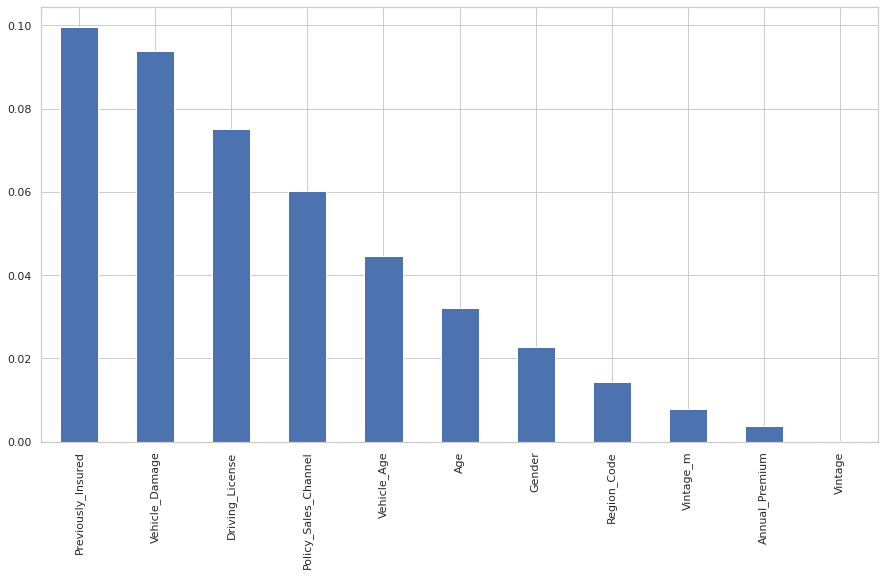

In [21]:
# and now let's plot the ordered MI values per feature
mi.sort_values(ascending=False).plot.bar(figsize=(15, 8))

As we observe converting the Vintage from days into Month is helping us to get good relationship between the Vintage and Target Variable.

In [22]:
x_train_2 = x_train.drop(['Vintage'], axis = True)
test_2 = test.drop(['Vintage'], axis = True)

In [23]:
x_train_2.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage_m
0,1.0,44.0,1.0,28.0,0.0,2.0,1.0,40454.0,26.0,8.0
1,1.0,76.0,1.0,3.0,0.0,1.0,0.0,33536.0,26.0,7.0
2,1.0,47.0,1.0,28.0,0.0,2.0,1.0,38294.0,26.0,1.0
3,1.0,21.0,1.0,11.0,1.0,0.0,0.0,28619.0,152.0,7.0
4,0.0,29.0,1.0,41.0,1.0,0.0,0.0,27496.0,152.0,2.0


In [24]:
x_train_2 = x_train_2.astype(int)
test_2 = test_2.astype(int)

In [25]:
x_train_2.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage_m
0,1,44,1,28,0,2,1,40454,26,8
1,1,76,1,3,0,1,0,33536,26,7
2,1,47,1,28,0,2,1,38294,26,1
3,1,21,1,11,1,0,0,28619,152,7
4,0,29,1,41,1,0,0,27496,152,2


In [26]:
test_2.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage_m
0,1,25,1,11,1,0,0,35786,152,2
1,1,40,1,28,0,1,1,33762,7,4
2,1,47,1,28,0,1,1,40050,124,7
3,1,24,1,27,1,0,1,37356,152,7
4,1,27,1,28,1,0,0,59097,152,10


In [27]:
# categorical column 
cat_col=['Gender', 'Vintage_m', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage','Policy_Sales_Channel']

In [28]:
x_train_2['type'] = 'train'
test_2['type'] = 'test'

In [29]:
all_data = pd.concat([x_train_2, test_2])

In [30]:
all_data.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage_m,type
0,1,44,1,28,0,2,1,40454,26,8,train
1,1,76,1,3,0,1,0,33536,26,7,train
2,1,47,1,28,0,2,1,38294,26,1,train
3,1,21,1,11,1,0,0,28619,152,7,train
4,0,29,1,41,1,0,0,27496,152,2,train


In [31]:
# Numerical Column
numerical_cols = ['Annual_Premium', 'Age']

scaler = MinMaxScaler()
all_data[numerical_cols] = scaler.fit_transform(all_data[numerical_cols])

all_data.head()


,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage_m,type
0,1,0.369231,1,28,0,2,1,0.070366,26,8,train
1,1,0.861538,1,3,0,1,0,0.057496,26,7,train
2,1,0.415385,1,28,0,2,1,0.066347,26,1,train
3,1,0.015385,1,11,1,0,0,0.048348,152,7,train
4,0,0.138462,1,41,1,0,0,0.046259,152,2,train


In [32]:
df_train = all_data[all_data['type'] == 'train']
df_test = all_data[all_data['type'] == 'test']

In [33]:
df_train = df_train.drop(['type'], axis = 1)
df_test = df_test.drop(['type'], axis = 1)

In [34]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(df_train, y_train, test_size=.25, random_state=42,stratify=y_train,shuffle=True)

In [35]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
catb = CatBoostClassifier(eval_metric = 'AUC')
catb= catb.fit(X_train, Y_train,cat_features=cat_col,eval_set=(X_test, Y_test),early_stopping_rounds=50,verbose=1000)
y_cat = catb.predict(X_test)
probs_cat_train = catb.predict_proba(X_train)[:, 1]
probs_cat_test = catb.predict_proba(X_test)[:, 1]
roc_auc_score(Y_train, probs_cat_train)
roc_auc_score(Y_test, probs_cat_test)

Learning rate set to 0.128106
0:	test: 0.8348163	best: 0.8348163 (0)	total: 271ms	remaining: 4m 30s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8592072112
bestIteration = 161

Shrink model to first 162 iterations.


0.8592072111835038

In [36]:
col=['Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage_m']

In [37]:
submmission = pd.read_csv('/kaggle/input/health-insurance-cross-sell-prediction/sample_submission.csv')

In [38]:
cat_pred= catb.predict_proba(df_test[col])[:, 1]
submmission['Response']=cat_pred
submmission.to_csv("cat_after_FE.csv", index = False)

In [39]:
submmission.head()

,id,Response
0,381110,0.000336
1,381111,0.273829
2,381112,0.283915
3,381113,0.005519
4,381114,0.000270


## LIGHT GBM

In [40]:
import warnings
warnings.filterwarnings("ignore")
import lightgbm as lgb
from bayes_opt import BayesianOptimization

def bayes_parameter_opt_lgb(X_train, Y_train, init_round=15, opt_round=25, n_folds=5, random_seed=6, n_estimators=10000, learning_rate=0.05, output_process=False):
    train_data = lgb.Dataset(data=X_train, label=Y_train, categorical_feature = cat_col, free_raw_data=False)
    # parameters
    def lgb_eval(num_leaves,min_child_samples, feature_fraction, bagging_fraction, max_depth, lambda_l1, lambda_l2, min_split_gain, min_child_weight):
        params = {'application':'binary','num_iterations': n_estimators, 'learning_rate':learning_rate, 'early_stopping_round':100, 'metric':'auc'}
        params["num_leaves"] = int(round(num_leaves))
        params["min_child_samples"] = int(round(min_child_samples))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['lambda_l1'] = max(lambda_l1, 0)
        params['lambda_l2'] = max(lambda_l2, 0)
        params['min_split_gain'] = min_split_gain
        params['min_child_weight'] = min_child_weight
        cv_result = lgb.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=True, shuffle=True, verbose_eval =200, metrics=['auc'])
        return max(cv_result['auc-mean'])
    # range 
    lgbBO = BayesianOptimization(lgb_eval, {'num_leaves': (24, 45),
                                        'min_child_samples': (10,500),
                                        'feature_fraction': (0.1, 0.9),
                                        'bagging_fraction': (0.5, 1),
                                        'max_depth': (5, 9),
                                        'lambda_l1': (0, 5),
                                        'lambda_l2': (0, 3),
                                        'min_split_gain': (0.001, 0.1),                                        
                                        'min_child_weight': (5, 50)}, random_state=0)
# optimize
    lgbBO.maximize(init_points=init_round, n_iter=opt_round)

    model_auc=[]
    for model in range(len( lgbBO.res)):
        model_auc.append(lgbBO.res[model]['target'])

    # return best parameters
    return lgbBO.res[pd.Series(model_auc).idxmax()]['target'],lgbBO.res[pd.Series(model_auc).idxmax()]['params']


In [41]:
opt_params = bayes_parameter_opt_lgb(X_train, Y_train, init_round=20, opt_round=50, n_folds=3, random_seed=6, n_estimators=1000, learning_rate=0.05)

|   iter    |  target   | baggin... | featur... | lambda_l1 | lambda_l2 | max_depth | min_ch... | min_ch... | min_sp... | num_le... |
-------------------------------------------------------------------------------------------------------------------------------------
[200]	cv_agg's auc: 0.857697 + 0.000411386
|  1        |  0.8577   |  0.7744   |  0.6722   |  3.014    |  1.635    |  6.695    |  326.5    |  24.69    |  0.08929  |  44.24    |
[200]	cv_agg's auc: 0.857574 + 0.000300557
|  2        |  0.8577   |  0.6917   |  0.7334   |  2.644    |  1.704    |  8.702    |  44.81    |  8.921    |  0.003002 |  41.49    |
[200]	cv_agg's auc: 0.85736 + 0.000250035
|  3        |  0.8574   |  0.8891   |  0.796    |  4.893    |  2.397    |  6.846    |  392.5    |  10.32    |  0.06435  |  27.01    |
[200]	cv_agg's auc: 0.857716 + 0.000336999
|  4        |  0.8578   |  0.9723   |  0.5175   |  2.073    |  0.7937   |  8.097    |  233.5    |  30.58    |  0.00286  |  36.97    |
[200]	cv_agg's auc: 0.857

In [42]:
(opt_params)

(0.8581846348221301,
 {'bagging_fraction': 0.6748413432573791,
  'feature_fraction': 0.3679391904942658,
  'lambda_l1': 0.12634823005251483,
  'lambda_l2': 2.5758763661356947,
  'max_depth': 5.6332944140235,
  'min_child_samples': 67.7903834682566,
  'min_child_weight': 13.230620628598382,
  'min_split_gain': 0.049593356088361185,
  'num_leaves': 29.807441218992093})

In [43]:
opt_parameters = opt_params[1]

In [44]:
opt_parameters["bagging_fraction"]

0.6748413432573791

In [45]:
import lightgbm as lgb
opt_model_lgb = lgb.LGBMClassifier(bagging_fraction = opt_parameters["bagging_fraction"],
                                   feature_fraction = opt_parameters["feature_fraction"],
                                   lambda_l1 = opt_parameters["lambda_l1"],
                                   lambda_l2 = opt_parameters["lambda_l2"],
                                   max_depth = int(round(opt_parameters["max_depth"])),
                                   min_child_weight = opt_parameters["min_child_weight"],
                                   min_child_samples = int(round(opt_parameters["min_child_samples"])),
                                   min_split_gain = opt_parameters["min_split_gain"],
                                   num_leaves = int(round(opt_parameters["num_leaves"]))
                                    )

In [46]:
opt_model_lgb.fit(X_train,Y_train)

LGBMClassifier(bagging_fraction=0.6748413432573791,
               feature_fraction=0.3679391904942658,
               lambda_l1=0.12634823005251483, lambda_l2=2.5758763661356947,
               max_depth=6, min_child_samples=68,
               min_child_weight=13.230620628598382,
               min_split_gain=0.049593356088361185, num_leaves=30)

In [47]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import roc_auc_score
probs_lgb_train = opt_model_lgb.predict_proba(X_train)[:, 1]
probs_lgb_test = opt_model_lgb.predict_proba(X_test)[:, 1]
roc_auc_score(Y_train, probs_lgb_train)
roc_auc_score(Y_test, probs_lgb_test)
pred_lgb = opt_model_lgb.predict_proba(X_test)
roc_auc_score(Y_test, probs_lgb_test)

0.8582369759806809

In [48]:
lgb_pred= opt_model_lgb.predict_proba(df_test[col])[:, 1]
submmission['Response']=lgb_pred
submmission.to_csv("lgb_after_FE.csv", index = False)

## Average of all three Models

In [49]:
average_pred = (cat_pred + lgb_pred)/2

In [50]:
average_pred[:5]

array([0.00078155, 0.28386579, 0.29581126, 0.00575326, 0.00049978])

In [51]:
submmission['Response']=average_pred
submmission.to_csv("Stacking_of_CAT_LGB_after_FE.csv", index = False)